In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 8)

import pandas as pd
import random
import statistics
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
type_target = 'arrivees_urgences'
assert type_target in ['hospitalisations', 'arrivees_urgences']

In [3]:
if type_target == 'hospitalisations':
    '''
    df = pd.read_csv('target.csv', sep=';')
    '''
    df = pd.read_csv('RPU_vers_hospit_adultes.csv', sep=';')
    df['date_entree'] = pd.to_datetime(df['date_entree'], format="%d/%m/%Y")
    df.rename({'Total': type_target}, axis=1, inplace=True)
    df['target'] = df[type_target].copy()
    # on ajoute les arrivées aux urgences, que l'on suppose connues pour le jour J
    dff = pd.read_feather('CHU Dijon_volumes.feather')
    dff.rename({'Total': 'arrivees_urgences'}, axis=1, inplace=True)
    dff.reset_index(inplace=True)
    df = pd.merge(df, dff, on='date_entree')
else:
    df = pd.read_feather('CHU Dijon_volumes.feather')
    df.rename({'Total': type_target}, axis=1, inplace=True)

In [4]:
# On ajoute la target
if type_target == 'hospitalisations':
    horizon = 7
else:
    horizon = 3
df['mean'] = df[type_target].rolling(window=horizon, min_periods=1).mean()
df['target'] = df['mean'].shift(-2*horizon+1)
df.drop('mean', axis=1, inplace=True)
df.dropna(inplace=True)
df.shape

(1821, 2)

In [5]:
# On ajoute les features
dg = pd.read_csv('features_all_origin.csv', sep=',')
dg.drop('Total', axis=1, inplace=True)
dg['date_entree'] = pd.to_datetime(dg['date_entree'], format="%Y-%m-%d")
dff = pd.merge(df, dg, on='date_entree', how='left')
dff.set_index('date_entree', inplace=True)

<AxesSubplot: xlabel='date_entree'>

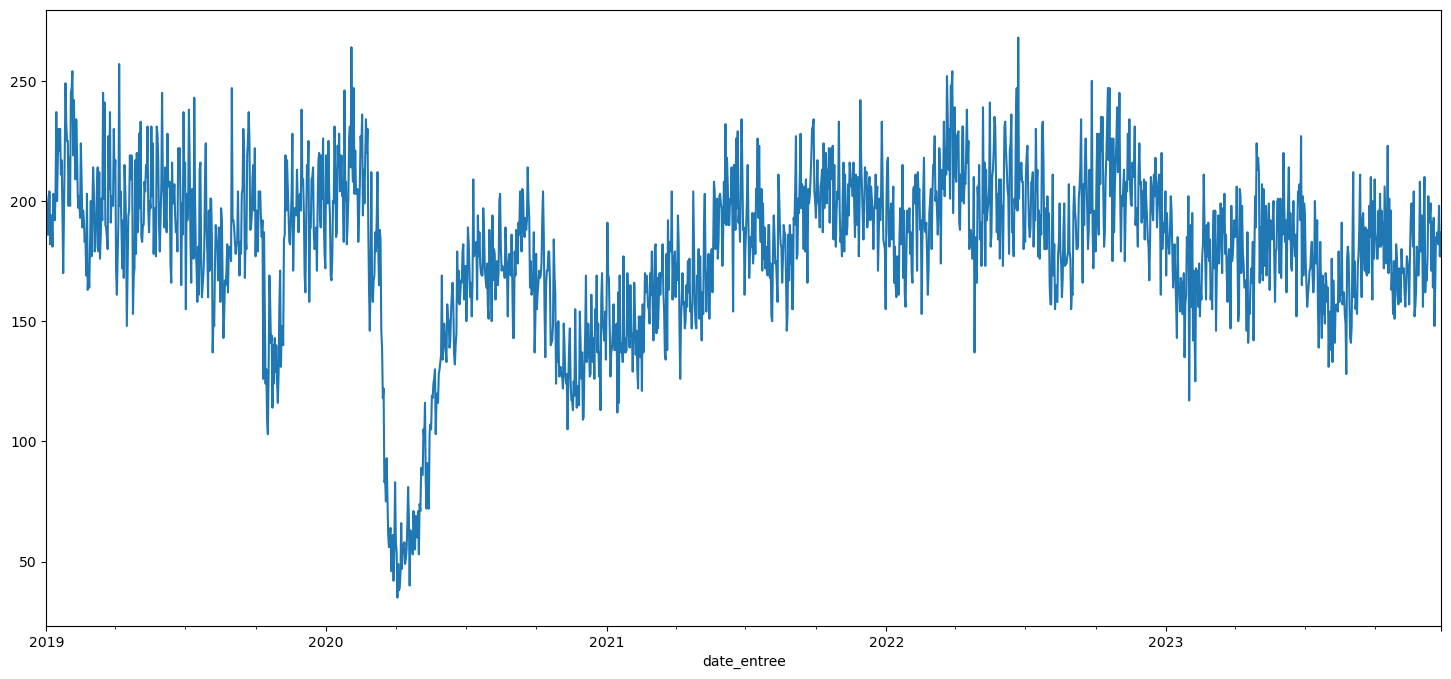

In [6]:
df[type_target].plot()

In [7]:
dff = dff.drop(dff.loc['2020-03':'2020-05'].index)

In [8]:
df = dff[[type_target, 'target']]

In [9]:
def teste(df, params, score=100000):
    MAEs, MSEs = [], []
    tscv = TimeSeriesSplit(n_splits=2)
    for train_index, test_index in tscv.split(df):
        train_val, test = df.iloc[train_index], df.iloc[test_index]
        X_test = test.drop('target', axis=1)
        y_test = test['target']
        X_train, X_valid, y_train, y_valid = train_test_split(train_val.drop('target', axis=1), train_val['target'], 
                                                              test_size=0.2, shuffle=False)
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        dtest = xgb.DMatrix(X_test, label=y_test)
        evals = [(dtrain, 'train'), (dvalid, 'eval')]
        bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                        early_stopping_rounds=15, verbose_eval=False)
    
        y_pred = bst.predict(dtest)
        MAEs.append(mean_absolute_error(y_test, y_pred))
        MSEs.append(mean_squared_error(y_test, y_pred))

    if statistics.mean(MSEs) < score:
        plt.figure()
        plt.plot(range(len(y_test)), y_test, label='actual')
        plt.plot(range(len(y_pred)), y_pred, label='predict')
        plt.legend()
        print(f"   - MAE : {statistics.mean(MAEs):.2f}")
        print(f"   - MSE : {statistics.mean(MSEs):.2f}")
    return MSEs

   - MAE : 15.11
   - MSE : 368.50


[431.3664316447005, 305.6427108531745]

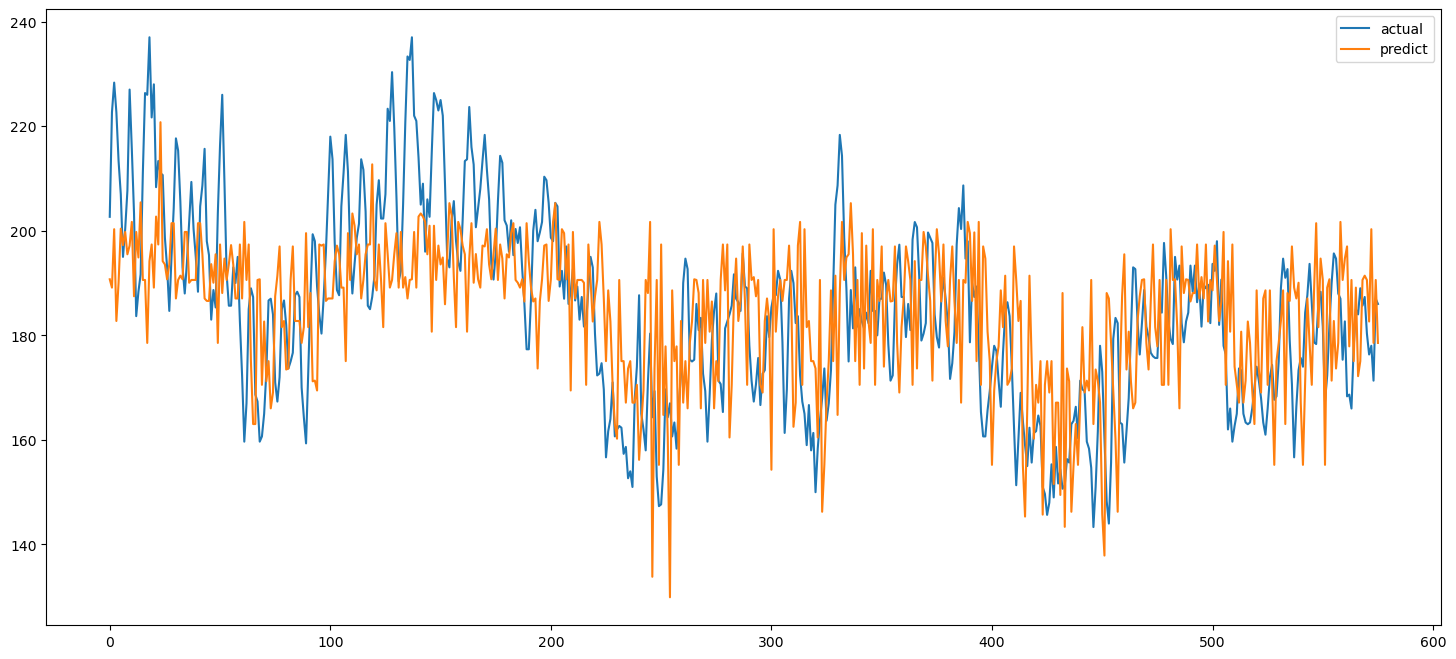

In [10]:
params = {
    'max_depth': 4,
    'seed': 42,
    'eta': 0.5
}

teste(df, params)

/tmp/ipykernel_3381703/3129698392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'day_of_week'] = df.index.dayofweek


   - MAE : 13.17
   - MSE : 275.68


[288.41647256523254, 262.9512649664457]

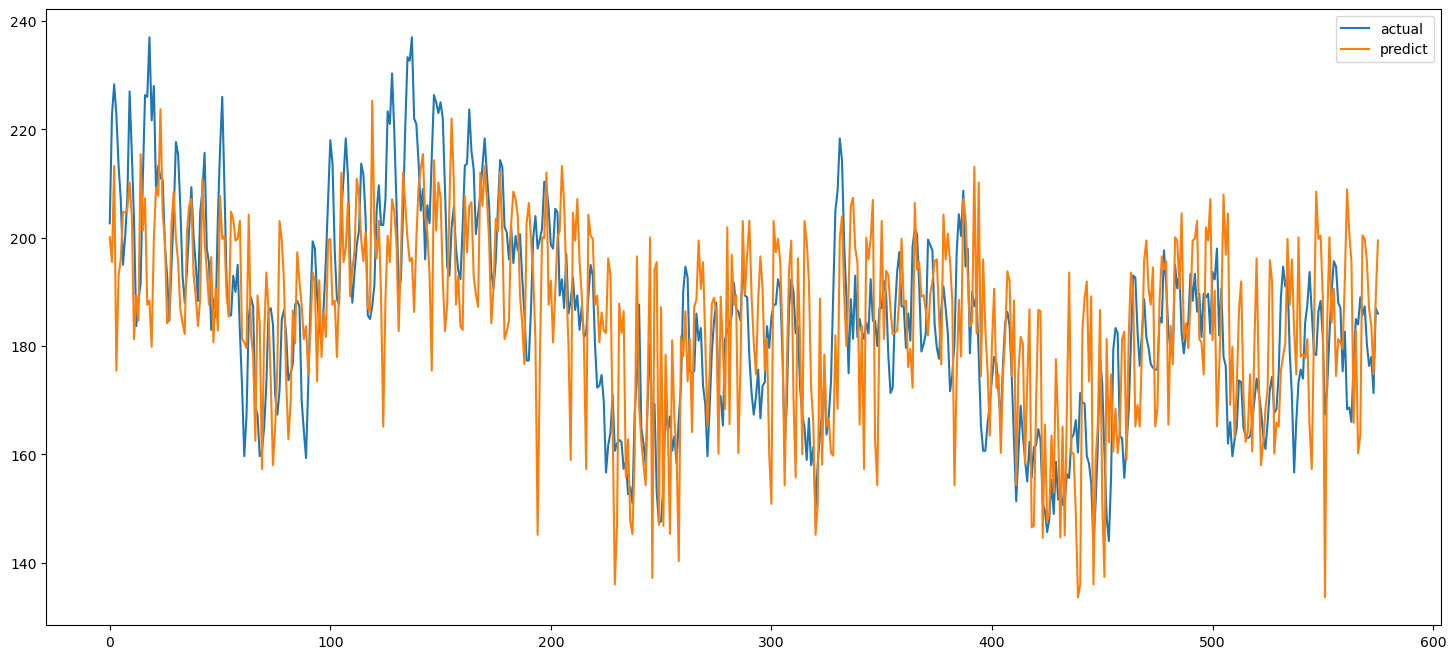

In [11]:
df.loc[:, 'day_of_week'] = df.index.dayofweek
teste(df, params)

/tmp/ipykernel_3381703/1356067369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f"{type_target}-{pas}"] = df[type_target].shift(pas)
/tmp/ipykernel_3381703/1356067369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f"{type_target}-{pas}"] = df[type_target].shift(pas)
/tmp/ipykernel_3381703/1356067369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

   - MAE : 11.60
   - MSE : 212.07


[230.47378999492352, 193.67256855022845]

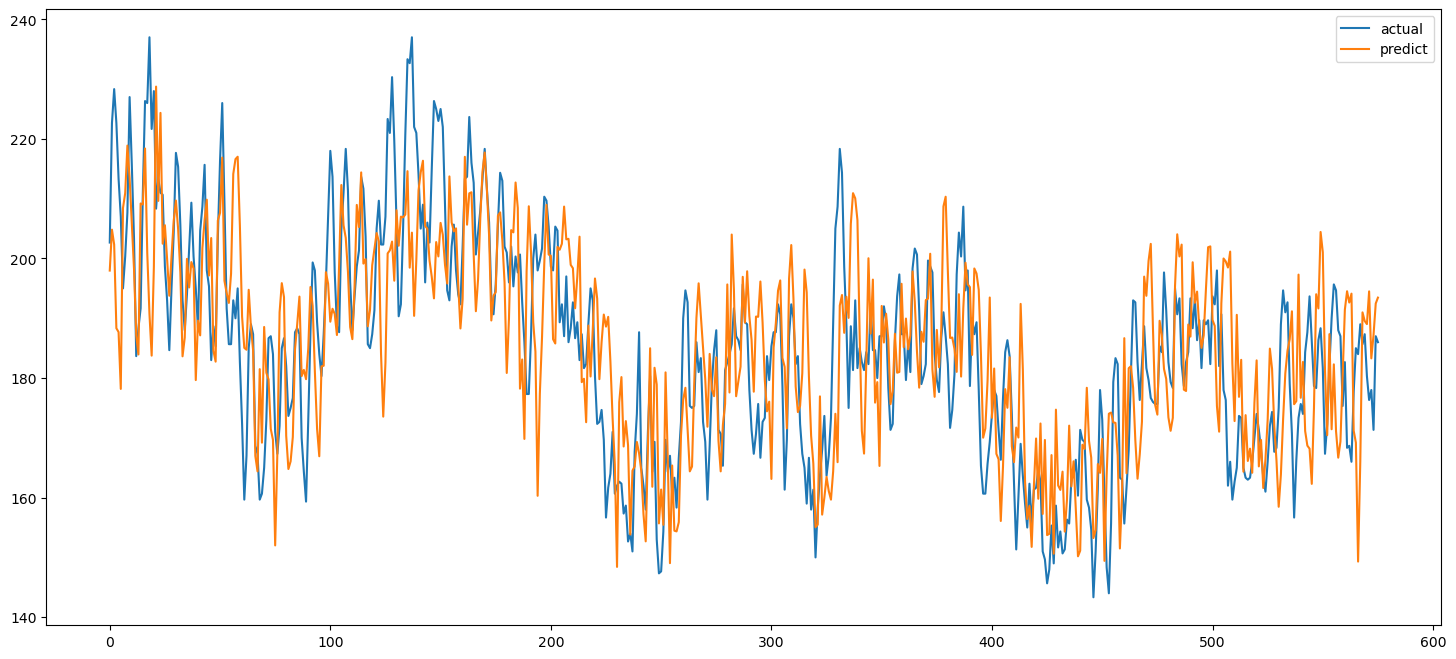

In [12]:
for pas in range(1, horizon+1):
    df.loc[:, f"{type_target}-{pas}"] = df[type_target].shift(pas)
teste(df, params)

   - MAE : 11.12
   - MSE : 200.51


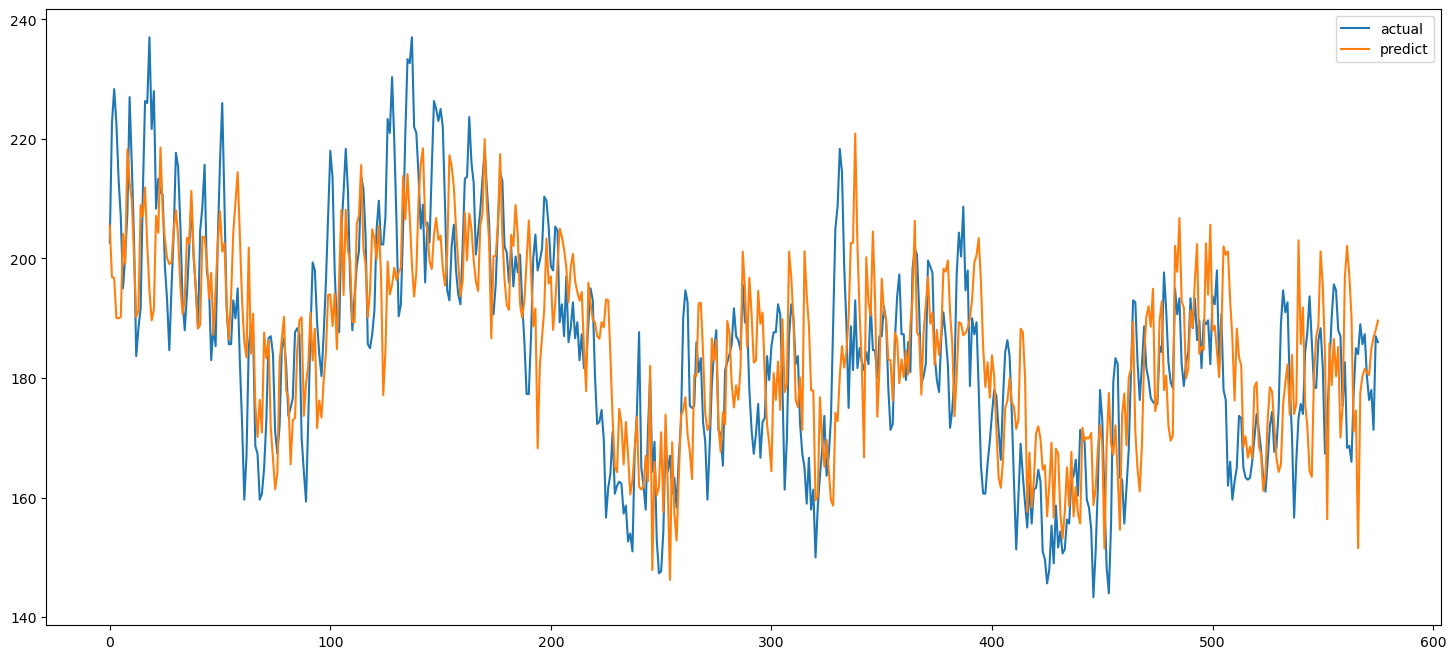

In [16]:
params = {
    'max_depth': 5,
    'seed': 42,
    'eta': 0.1
}

historique = 7
# On prédit la moyenne 3 jours dans 3 jours => 6 jours concernés
# => l'historique de la target "moyenne glissante" ne peut commencer qu'à J-7
assert historique > 2*horizon
df.loc[:, f'target-{historique}'] = df['target'].shift(historique)

score = statistics.mean(teste(df, params))

In [17]:
colonnes = [k for k in dff if k not in df]
random.shuffle(colonnes)

In [ ]:
index = 0

In [25]:
col = colonnes[index]
if col not in df:
    print(f"{index+1}/{len(colonnes)}: {col}")
    dg = df.copy()
    dg[col] = dff[col]
    for max_depth in range(4, 6):
        params['max_depth'] = max_depth
        mse = statistics.mean(teste(dg, params, score))
        if mse < score:
            print(f"  => amélioration: {score:.4f} -> {mse:.4f}")
            score = mse
            df = dg.copy()
            print("     features : "+', '.join(df.columns))
    index += 1

9/1092: trend_palpitations_J-6


In [ ]:
mse

NameError: name 'llm' is not defined